#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # Validation

 **Objectifs d'apprentissage :**
  * Utiliser plusieurs caractéristiques, plutôt qu'une seule, pour améliorer encore l'efficacité d'un modèle
  * Déboguer les erreurs au niveau des données d'entrée du modèle
  * Utiliser un ensemble de données d'évaluation pour déterminer si un modèle surapprend les données de validation

 Comme pour les exercices précédents, vous allez utiliser l'ensemble de données sur l'immobilier en Californie pour tâcher de prédire la valeur médiane des logements (`median_house_value`) au niveau de l'îlot urbain, sur la base du recensement de 1990.

 ## Configuration

 Commencez par charger et préparer les données. Cette fois, vous allez utiliser plusieurs caractéristiques. Vous allez donc modulariser la logique pour prétraiter un peu les caractéristiques :

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

# california_housing_dataframe = california_housing_dataframe.reindex(
#     np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

 Pour l'**ensemble d'apprentissage**, vous allez choisir les 12 000 premiers exemples, sur un total de 17 000.

In [4]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,34.6,-118.5,27.5,2655.7,547.1,1476.0,505.4,3.8,1.9
std,1.6,1.2,12.1,2258.1,434.3,1174.3,391.7,1.9,1.3
min,32.5,-121.4,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.8,-118.9,17.0,1451.8,299.0,815.0,283.0,2.5,1.4
50%,34.0,-118.2,28.0,2113.5,438.0,1207.0,411.0,3.5,1.9
75%,34.4,-117.8,36.0,3146.0,653.0,1777.0,606.0,4.6,2.3
max,41.8,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


In [5]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,198.0
std,111.9
min,15.0
25%,117.1
50%,170.5
75%,244.4
max,500.0


 Pour l'**ensemble de validation**, vous allez choisir les 5 000 derniers exemples, sur un total de 17 000.

In [6]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,38.1,-122.2,31.3,2614.8,521.1,1318.1,491.2,4.1,2.1
std,0.9,0.5,13.4,1979.6,388.5,1073.7,366.5,2.0,0.6
min,36.1,-124.3,1.0,8.0,1.0,8.0,1.0,0.5,0.1
25%,37.5,-122.4,20.0,1481.0,292.0,731.0,278.0,2.7,1.7
50%,37.8,-122.1,31.0,2164.0,424.0,1074.0,403.0,3.7,2.1
75%,38.4,-121.9,42.0,3161.2,635.0,1590.2,603.0,5.1,2.4
max,42.0,-121.4,52.0,32627.0,6445.0,28566.0,6082.0,15.0,18.3


In [7]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,229.5
std,122.5
min,15.0
25%,130.4
50%,213.0
75%,303.2
max,500.0


 ## Tâche 1 : Examiner les données
Examinons les données ci-dessus. On voit que `9` caractéristiques d'entrée peuvent être utilisées.

Jetez un rapide coup d'œil sur le tableau des valeurs. Tout vous semble correct ? Voyez combien de problèmes vous pouvez relever. Ne vous inquiétez pas, aucune connaissance en statistiques n'est requise. Il suffit de faire preuve de bon sens.

Après avoir eu l'occasion d'examiner les données par vous-même, consultez la solution. Vous y trouverez d'autres idées sur la manière de valider les données.

 ### Solution

Cliquez ci-dessous pour afficher la solution.

 Voyons si les données sont conformes à quelques attentes élémentaires :

* Pour certaines valeurs, telles que `median_house_value`, vous pouvez vérifier si les plages sont acceptables (pour rappel, ces données datent de 1990 !).

* Pour d'autres valeurs, comme `latitude` et `longitude`, vous pouvez vérifier rapidement à l'aide d'une recherche Google si elles sont conformes aux résultats que l'on s'attend à obtenir.

En y regardant de plus près, on peut constater quelques anomalies :

* La valeur `median_income` se situe sur une échelle allant d'environ 3 à 15. Rien ne permet de déterminer avec certitude à quoi cette échelle fait référence : peut-être s'agit-il d'une échelle logarithmique ? On ne trouve aucune information à ce sujet ; on peut simplement supposer que les valeurs plus élevées correspondent à un revenu supérieur.

* La valeur `median_house_value` maximale est de 500 001. Cela ressemble à une limite artificielle.

* La caractéristique `rooms_per_person` se trouve généralement sur une échelle raisonnable, avec une valeur du 75e percentile correspondant approximativement à 2. Il existe toutefois quelques valeurs particulièrement grandes, comme 18 ou 55, qui peuvent indiquer une certaine corruption des données.

Pour l'instant, vous utiliserez ces caractéristiques telles quelles. Cependant, on peut espérer que des exemples de ce type vous aident à comprendre comment vérifier les données qui vous arrivent en provenance d'une source inconnue.

 ## Tâche 2 : Représenter graphiquement la latitude/longitude par rapport à la valeur médiane des logements

 Examinons deux caractéristiques en particulier : **`latitude`** et **`longitude`**. Il s'agit des coordonnées géographiques de l'îlot urbain étudié.

Cela peut produire une belle visualisation. Vous allez représenter graphiquement `latitude` et `longitude`, puis utiliser des couleurs pour afficher la valeur médiane des logements (`median_house_value`).

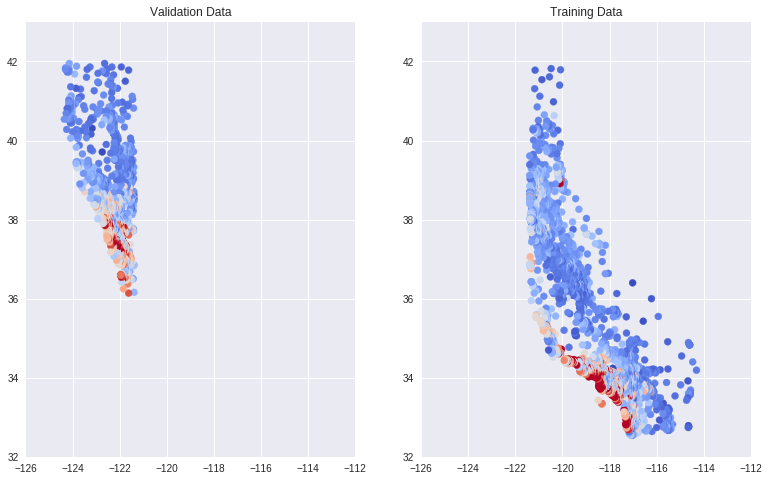

In [8]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            cmap="coolwarm",
            c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())
_ = plt.plot()

 Une seconde ! Nous aurions dû avoir une belle carte de l’État de Californie, sur laquelle les villes les plus chères, comme San Francisco et Los Angeles, sont indiquées en rouge.

C'est en quelque sorte ce que fait l'ensemble d'apprentissage, par rapport à une [carte réelle](https://www.google.com/maps/place/California/@37.1870174,-123.7642688,6z/data=!3m1!4b1!4m2!3m1!1s0x808fb9fe5f285e3d:0x8b5109a227086f55), mais ce n'est, de toute évidence, pas le cas de l'ensemble de validation.

**Revenez en arrière et examinez à nouveau les données de la Tâche 1.**

Voyez-vous d'autres différences dans les répartitions de caractéristiques ou cibles entre les données d'apprentissage et de validation ?

 ### Solution

Cliquez ci-dessous pour afficher la solution.

 En observant les tableaux de statistiques récapitulatives ci-dessus, on est droit de se demander comment quelqu'un pourrait bien effectuer une vérification utile des données. Quelle est la valeur correcte du 75<sup>e</sup> percentile pour le nombre total de pièces (total_rooms) par îlot urbain ?

Il est important de noter que, pour une caractéristique ou une colonne donnée, la répartition des valeurs entre les ensembles d'apprentissage et de validation devrait être sensiblement égale.

Le fait que cela ne soit pas le cas est vraiment préoccupant, et indique une probable erreur dans la méthode utilisée pour créer les ensembles d'apprentissage et de validation.

 ## Tâche 3 : Revenir au code d'importation et de prétraitement des données, et détecter d'éventuels bugs
Le cas échéant, corrigez le bug. Ne passez pas plus d'une ou deux minutes à rechercher le bug. Si vous ne le trouvez pas, vérifiez la solution.

 Après avoir détecté et corrigé l'erreur, exécutez à nouveau la cellule de traçage `latitude`/`longitude` ci-dessus et confirmez l'amélioration des évaluations d'intégrité.

Au passage, signalons qu'il y a ici un enseignement important à tirer.

**Dans le domaine du ML, le débogage s'apparente davantage à du *débogage de données* qu'à du débogage de code.**

Si les données sont erronées, même le code ML le plus sophistiqué ne peut pas faire de miracles.

 ### Solution

Cliquez ci-dessous pour afficher la solution.

 Voyons à présent comment les données sont rendues aléatoires lors de leur lecture.

Si une application aléatoire des données n'est pas effectuée correctement avant de créer des ensembles d'apprentissage et de validation, des problèmes peuvent survenir en cas d'obtention de données classées ; ce qui semble être le cas ici.

 ## Tâche 4 : Entraîner et évaluer un modèle

**Consacrez environ cinq minutes à expérimenter différents hyperparamètres. Essayez d'obtenir les meilleures performances de validation possibles.**

Vous allez ensuite entraîner une variable indépendante linéaire à l'aide de toutes les caractéristiques dans l'ensemble de données et voir quel est le résultat.

Définissez la même fonction d'entrée que celle utilisée précédemment pour charger les données dans un modèle TensorFlow.


In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

 Étant donné que vous travaillez à présent avec plusieurs caractéristiques d'entrée, vous allez modulariser le code pour configurer des colonnes de caractéristiques dans une fonction distincte. Pour l'instant, ce code est relativement simple, car toutes les caractéristiques sont numériques. Cependant, nous allons le développer à mesure que nous utiliserons d'autres types de caractéristiques dans les prochains exercices.)

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

 Vous allez maintenant exécuter le code `train_model()` ci-dessous pour configurer les fonctions d'entrée et calculer des prédictions.

**REMARQUE :** Il est permis de faire référence au code des exercices précédents, mais veillez à appeler `predict()` sur les ensembles de données appropriés.

Comparez les coûts sur les données d'apprentissage et de validation. Avec une seule caractéristique brute, la meilleure valeur RMSE (racine carrée de l'erreur quadratique moyenne) obtenue était d'environ 180.

Voyons maintenant dans quelle mesure l'utilisation de plusieurs caractéristiques peut être bénéfique.

Vérifiez les données en utilisant quelques-unes des méthodes mentionnées précédemment, à savoir :

   * Comparaison des répartitions de prédictions et des valeurs cibles réelles

   * Création d'un diagramme de dispersion des prédictions par rapport aux valeurs cibles

   * Création de deux diagrammes de dispersion des données de validation à l'aide de `latitude` et `longitude` :
      * Un diagramme associant une couleur à la valeur `median_house_value` cible réelle
      * Un deuxième diagramme associant une couleur à la valeur `median_house_value` prédite pour un affichage comparatif.

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # 1. Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # 2. Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 226.04
  period 01 : 224.66
  period 02 : 223.31
  period 03 : 221.93
  period 04 : 220.58
  period 05 : 219.24
  period 06 : 217.88
  period 07 : 216.55
  period 08 : 215.21
  period 09 : 213.90
Model training finished.


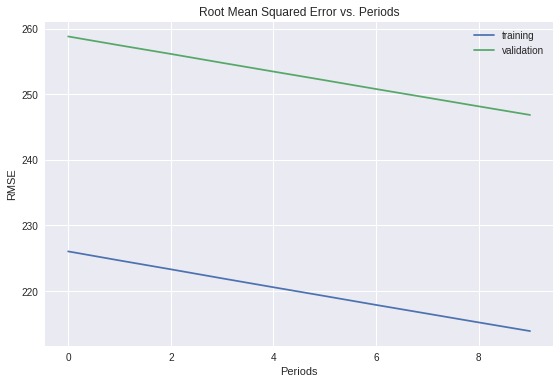

In [14]:
linear_regressor = train_model(
    # TWEAK THESE VALUES TO SEE HOW MUCH YOU CAN IMPROVE THE RMSE
    learning_rate=0.00001,
    steps=100,
    batch_size=1,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ### Solution

Cliquez ci-dessous pour afficher une solution.

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 166.56
  period 01 : 199.04
  period 02 : 160.02
  period 03 : 164.44
  period 04 : 157.50
  period 05 : 160.71
  period 06 : 158.39
  period 07 : 167.74
  period 08 : 158.20
  period 09 : 162.21
Model training finished.


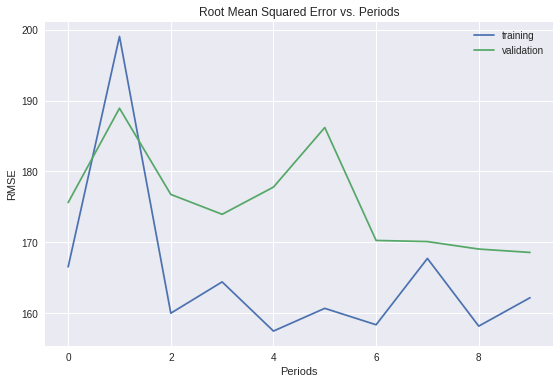

In [17]:
linear_regressor = train_model(
    learning_rate=0.001,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## Tâche 5 : Effectuer une évaluation sur les données de test

**Dans la cellule ci-dessous, chargez l'ensemble de données de test et évaluez votre modèle sur celui-ci.**

Les données de validation ayant fait l'objet de nombreuses itérations, assurez-vous qu'il n'y a pas eu de surapprentissage des particularités de cet échantillon.

Les données de test se trouvent [ici](https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv).

Comment vos performances de test se comparent-elles aux performances de validation ? Qu'est-ce que cela nous apprend sur les performances de généralisation de votre modèle ?

In [0]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")
#
# YOUR CODE HERE
#

 ### Solution

Cliquez ci-dessous pour afficher la solution.

In [19]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
      test_examples, 
      test_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 158.18
